## Validate
Using the same model, walk through what the inputs and corresponding predictions are at various depth intervals

In [1]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np

with open('vr_demo.csv', encoding='utf-8') as f:
    df = pd.read_csv(f, skipinitialspace=True, encoding='utf-8')
features = df.columns.values[:-1]
targets = df.columns.values[-1]
seed = 42
X, y = df[features], df[targets]
X_trn, X_test, y_trn, y_test = train_test_split(X, y, train_size=0.7, random_state=seed)

regressor = MLPRegressor(hidden_layer_sizes=(33, 33), solver='lbfgs', 
                         random_state=seed)
    
pipeline = Pipeline(steps=[
        ('Scale', StandardScaler()),
        ('Impute', SimpleImputer(strategy='mean')),#KNNImputer()),
        ('Regression', regressor)])
pipeline.fit(X_trn.values, y_trn.values)
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}, RMSE: {rmse:.2f}")

R²: 0.778, RMSE: 0.14


C:\Users\ChrisProsser\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ChrisProsser\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


long min max (x-axis): (-59.550925, -47.957358)
lat min max(y-axis): (44.023433, 47.122103)


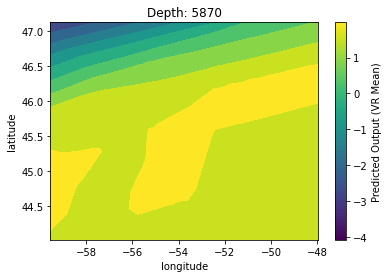

In [49]:
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\ChrisProsser\AppData\Roaming\ffmpeg\bin\ffmpeg.exe"
LEVELS = 8  # can make high e.g. 100 to get very smooth color gradient
CMAP = 'viridis'

# Create a figure and axis
fig, ax = plt.subplots()

# Set the depth range
depth, lat, lon = features[0], features[1], features[2]
depth_range = np.linspace(df[depth].min(), df[depth].max(), 200)
lat_range = np.linspace(df[lat].min(), df[lat].max(), 50)
lon_range = np.linspace(df[lon].min(), df[lon].max(), 50)
lat_grid, lon_grid = np.meshgrid(lat_range, lon_range)

# Compute all predictions ( order significant - features depth, lat, lon)
all_inputs = np.column_stack((np.repeat(depth_range, lat_grid.size), 
                              np.tile(lat_grid.flatten(), len(depth_range)), 
                              np.tile(lon_grid.flatten(), len(depth_range))))
all_predictions = pipeline.predict(all_inputs)
all_predictions = all_predictions.reshape(len(depth_range), lat_grid.shape[0], lat_grid.shape[1])

# Get the global minimum and maximum of all predictions to set the colorbar norm
vmin, vmax = all_predictions.min(), all_predictions.max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Create the colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=CMAP), ax=ax)
cbar.set_label('Predicted Output (VR Mean)')

# Intialise with zero depth
min_depth_grid = np.full(lat_grid.shape, df[depth].min())
cs = ax.contourf(lon_grid, lat_grid, min_depth_grid,
                 cmap=CMAP, levels=LEVELS, norm=norm)

# Define the function for updating the plot for each frame
def update(depth_index):
    depth = depth_range[depth_index]
    prediction_grid = all_predictions[depth_index]

    # Clear the axis contents
    ax.cla()
    
    # Create a contour plot of the model predictions
    cs = ax.contourf(lon_grid, lat_grid, prediction_grid, cmap=CMAP, 
                     levels=LEVELS, norm=norm)
    ax.set_title(f'Depth: {depth:.0f}')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')    
    
print(f"long min max (x-axis): {df[lon].min(), df[lon].max()}")
ax.set_xlim(df[lon].min(), df[lon].max())
print(f"lat min max(y-axis): {df[lat].min(), df[lat].max()}")
ax.set_ylim(df[lat].min(), df[lat].max())

# Create the animation using the update function and the depth range
ani = FuncAnimation(fig, update, interval=50, frames=range(len(depth_range)))
ani.save('contour_lat_lon_depth_ani.mp4', writer='ffmpeg', fps=20)

# Show the animation
HTML(ani.to_jshtml())


In [36]:
depth = depth_range[0];
print(f"Predictions @depth: {depth}")
# define boundaries
l,c,r = df[lon].min(), df[lon].median(), df[lon].max()
t,m,b = df[lat].max(), df[lat].median(), df[lat].min()
print(f"for Grid left, centre, right for each of top, mid, bottom")
coord = [[(t,l), (t,c), (t,r)], [(m,l), (m,c), (m,r)], [(b,l), (b,c), (b,r)]]
print([coord])

pipeline.predict([ # all @ lowest depth (855)
    [855, 47.1, -59], [855, 47.1, -54], [855, 47.1, -48], # NW, N, NE
    [855, 45.5, -59], [855, 45.5, -54], [855, 45.5, -48], # W, mid, E
    [855, 44, -59], [855, 44, -54], [855, 44, -48],       # SW, S, SE
]).reshape((3,3))

Predictions @depth: 855.0
for Grid left, centre, right for each of top, mid, bottom
[[(47.122103, -59.550925), (47.122103, -48.515478), (47.122103, -47.957358)], [(46.458689, -59.550925), (46.458689, -48.515478), (46.458689, -47.957358)], [(44.023433, -59.550925), (44.023433, -48.515478), (44.023433, -47.957358)]]


array([[-2.5634789 , -0.92026228,  0.24474464],
       [-0.13133744, -0.24894744, -0.47967408],
       [ 0.27470121, -0.50116178, -1.09335843]])

In [ ]:
pipeline.predict([[855, 44, -48]])

In [9]:
all_predictions.shape

(200, 50, 50)

In [11]:
all_predictions[0].shape

(50, 50)

In [13]:
all_predictions[0].min(), all_predictions[0].max() # first frame z values i.e. lowest depth

(-2.80258805315122, 0.42829604684193157)

In [15]:
all_predictions.min(), all_predictions.max()

(-4.073232955730574, 1.9801397862230279)

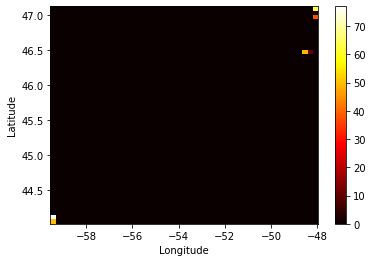

In [53]:
# Do we have tool little data at the boundaries of the grid for good predictions?
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from a csv file into a pandas DataFrame
df = pd.read_csv('vr_demo.csv')

# Extract the longitude and latitude columns from the DataFrame
x = df[lon]
y = df[lat]

# Create the 2D histogram using the hist2d method from matplotlib
plt.hist2d(x, y, bins=(50,50), cmap='hot')

# Add a colorbar to the plot
plt.colorbar()

# Set the x and y axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()